In [1]:
from locale import normalize

import keras.src.legacy.preprocessing.image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sympy.physics.units import inches
%matplotlib inline
import pywt
import tensorflow as tf
from skimage.color import rgb2gray

from keras import applications
from skimage.color import rgb2gray

import numpy as np

from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import utils
from keras import optimizers

import os
import sys

#image_folder = '/Volumes/Data/Docs/Kuliah/IITD Palmprint V1/Segmented/Right/'
#image_folder = '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Segmented/Left/'
image_folder = '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/ROI Left Hand/'

# sample image
img = cv2.imread( '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/ROI Left Hand/001_1.JPG')
img2 = cv2.imread( '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/ROI Left Hand/001_2.JPG')
img3 = cv2.imread( '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/ROI Left Hand/001_3.JPG')

batch_size = 32
no_of_epochs = 100


sys.setrecursionlimit(150000)

In [2]:
def w2d(img, mode='haar', level=1):
    image_data = img
    
    #Datatype conversions
    image_data = cv2.cvtColor( image_data,cv2.COLOR_RGB2GRAY )
    #convert to float
    image_data =  np.float32(image_data)
    image_data /= 255;
    # compute coefficients 
    coef=pywt.wavedec2(image_data, mode, level=level)

    #Process Coefficients
    coef_H=list(coef)
    coef_H[0] *= 0;

    # reconstruction
    image_data_H=pywt.waverec2(coef_H, mode);
    image_data_H *= 255;
    image_data_H =  np.uint8(image_data_H)

    return image_data_H

In [3]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [4]:
#filter name

In [5]:

def apply_canny_edge(image, low_threshold=50, high_threshold=150, blur_ksize=5):
    """
    Applies the Canny Edge Detection algorithm to the input image.

    Parameters:
        image (numpy.ndarray): Input image (grayscale or color).
        low_threshold (int): Lower bound for edge detection thresholds.
        high_threshold (int): Upper bound for edge detection thresholds.
        blur_ksize (int): Kernel size for Gaussian blur (must be an odd number).

    Returns:
        edges (numpy.ndarray): Binary image with edges highlighted.
    """
    # Convert to grayscale if the input image is in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Apply Gaussian Blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (blur_ksize, blur_ksize), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

    return edges

In [6]:
def get_palm_lines(image):
    rgb_planes = cv2.split(image)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        #clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        #norm_img = clahe.apply(norm_img)


        # Scale to range 0 to 255 for visualization purposes
        #        norm_img = (norm_img * 255).astype(np.uint8)

        #        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        #        norm_img = clahe.apply(norm_img)
        _, norm_img = cv2.threshold(norm_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        #       avg_intensity = np.mean(norm_img)

        # Set the new thresholds based on 25% of the average intensity
        #       dark_threshold = avg_intensity * 1.25  # Dark threshold is 125% of average intensity
        #       light_threshold = avg_intensity * 0.25  # Light threshold is 25% of average intensity

        # Apply the threshold conditions
        # multiply it?
        #        normalized_img = np.where(norm_img > dark_threshold, 0, norm_img)       # Darken pixels above dark threshold
        #        normalized_img = np.where(normalized_img < light_threshold, 255, normalized_img)  # Lighten pixels below light threshold

        #        norm_img = np.where(norm_img < 255, norm_img // 5, norm_img)
        #       norm_img[norm_img > 46] = 255

        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    return result_norm



In [7]:
def reduce_shadow(image):
    rgb_planes = cv2.split(image)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        norm_img = clahe.apply(diff_img)


        # Scale to range 0 to 255 for visualization purposes
        #        norm_img = (norm_img * 255).astype(np.uint8)

        #        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        #        norm_img = clahe.apply(norm_img)

        #       avg_intensity = np.mean(norm_img)

        # Set the new thresholds based on 25% of the average intensity
        #       dark_threshold = avg_intensity * 1.25  # Dark threshold is 125% of average intensity
        #       light_threshold = avg_intensity * 0.25  # Light threshold is 25% of average intensity

        # Apply the threshold conditions
        # multiply it?
        #        normalized_img = np.where(norm_img > dark_threshold, 0, norm_img)       # Darken pixels above dark threshold
        #        normalized_img = np.where(normalized_img < light_threshold, 255, normalized_img)  # Lighten pixels below light threshold

        #        norm_img = np.where(norm_img < 255, norm_img // 5, norm_img)
        #       norm_img[norm_img > 46] = 255

        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    return result_norm

In [8]:

def color_to_bw_and_normalize(image):
    """
    Converts a color image to grayscale and normalizes the intensity.

    Parameters:
        image (numpy.ndarray): Input color image (BGR format).

    Returns:
        normalized_bw (numpy.ndarray): Normalized grayscale image.
    """
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Normalize intensity to range 0–255
    normalized_bw = cv2.normalize(
        gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
    )

    return normalized_bw



In [9]:
def center_crop(image, crop_size=224):
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Calculate the center point
    center_x, center_y = width // 2, height // 2

    # Define the cropping box
    x_start = max(center_x - crop_size // 2, 0)
    y_start = max(center_y - crop_size // 2, 0)
    x_end = x_start + crop_size
    y_end = y_start + crop_size

    # Ensure the crop size does not exceed the image dimensions
    x_end = min(x_end, width)
    y_end = min(y_end, height)

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    # Convert to grayscale if the image is in color
#    if len(cropped_image.shape) == 3:
 #       cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        
    return cropped_image

In [10]:
img.shape

(224, 224, 3)

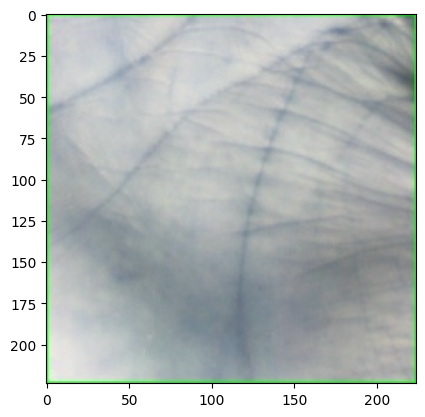

In [11]:
plt.imshow(img)

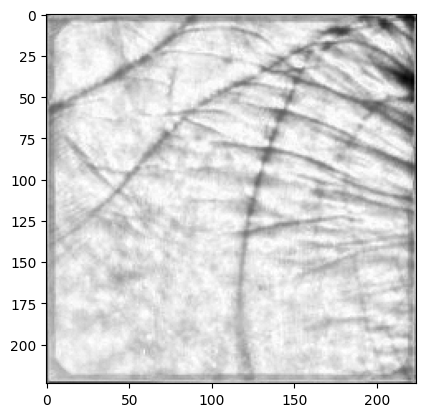

In [12]:
img_n = reduce_shadow(img)
img_bw = color_to_bw_and_normalize(img_n)
plt.imshow(img_bw, cmap='gray')

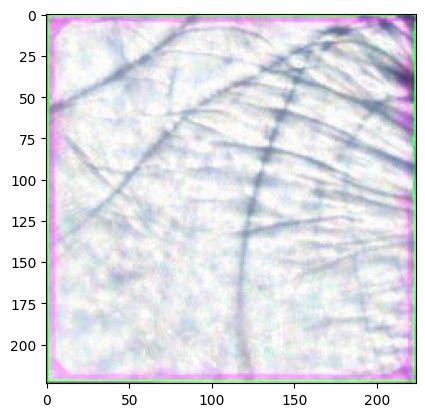

In [13]:
img_n = reduce_shadow(img)
plt.imshow(img_n)


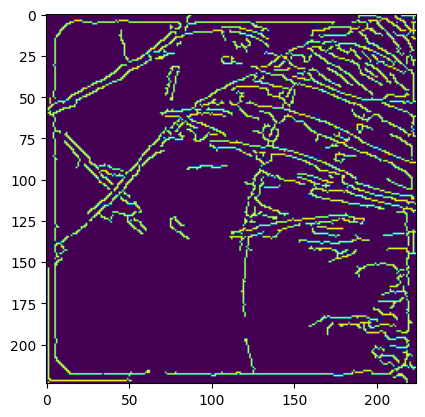

In [14]:
#img_canny = apply_canny_edge(img, 0 , 35)
img_canny = apply_canny_edge(img_n, 50 , 100)
plt.imshow(img_canny)

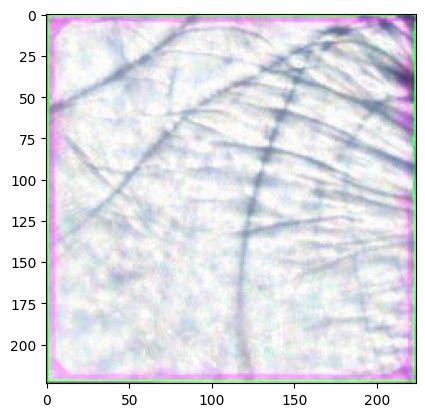

In [15]:
# Assuming result_norm is your processed image
result_norm = reduce_shadow(img)
#centered_crop = center_crop(result_norm, 224)

plt.imshow(result_norm)

In [16]:
def hough_transform_visualization(img, rho_resolution=1, theta_resolution=np.pi/180, threshold=100):
    """
    Perform Hough Transform on an image and visualize the results.

    Parameters:
    - img: Input image (RGB or grayscale)
    - rho_resolution: Distance resolution in pixels of the Hough grid
    - theta_resolution: Angle resolution in radians of the Hough grid
    - threshold: Accumulator threshold parameter for line detection
    
    Returns:
    - lines: Detected lines in the form of rho and theta pairs
    """
    # Convert image to grayscale if it is in RGB
    gray_img = rgb2gray(img) if img.ndim == 3 else img

    # Step 1: Apply edge detection (e.g., Canny) for the Hough transform input
    edges = cv2.Canny((gray_img * 255).astype(np.uint8), 50, 100)

    # Step 2: Perform Hough Transform using OpenCV
    lines = cv2.HoughLines(edges, rho_resolution, theta_resolution, threshold)

    # Create a blank image to accumulate lines
    accumulator = np.zeros_like(edges)
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * a)
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * a)
            cv2.line(accumulator, (x1, y1), (x2, y2), 255, 1)

    # Flatten the accumulator to create a feature vector
    feature_vector = accumulator.flatten()

    return feature_vector, lines
    

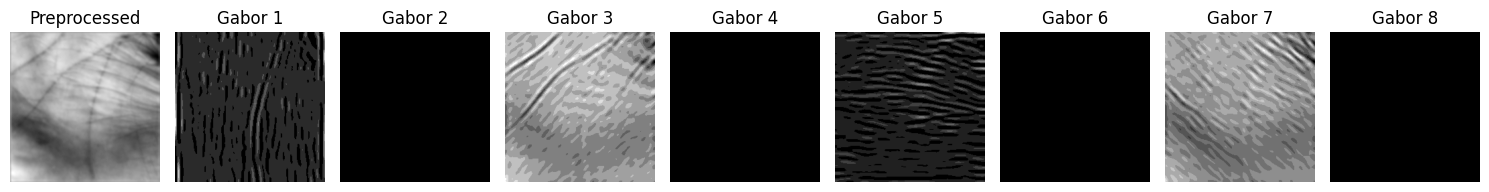

In [17]:
def load_image(image_path):
    """Load an image from the given path."""
    return cv2.imread(image_path)

def blur_to_gray_image(img):
    """Convert to grayscale and apply Gaussian blur."""
    gray_img = rgb2gray(img) if img.ndim == 3 else img
    blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    return blurred_img

def apply_gabor_filters(img, num_filters=8):
    """Apply Gabor filters to the image."""
    filters = []
    for theta in np.arange(0, np.pi, np.pi / num_filters):
        kernel = cv2.getGaborKernel((21, 21), 8.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        filters.append(filtered_img)
    return filters

def visualize_images(images, titles):
    """Visualize a list of images with titles."""
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Preprocess the image
preprocessed_img = blur_to_gray_image(img3)

# Apply Gabor filters
gabor_images = apply_gabor_filters(preprocessed_img)

# Visualize results
visualize_images([preprocessed_img] + gabor_images, ['Preprocessed'] + [f'Gabor {i+1}' for i in range(len(gabor_images))])

In [18]:

vgg16_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_base.layers:
    layer.trainable = False

# Function to extract features from palm images
def extract_features(dataset):
    features = vgg16_base.predict(dataset)
    return features


def normalize_palm_image(img):

    # Step 1: Histogram Equalization for contrast enhancement
    img = cv2.equalizeHist(img)

    # Step 2: Apply Gaussian Blur to smooth out noise while retaining edges
    img = cv2.GaussianBlur(img, (5, 5), 0)
#    plt.imshow(img)

    # Step 4: Apply adaptive thresholding to highlight the palm texture
    adaptive_thresh = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, blockSize=15, C=5)

    return adaptive_thresh


In [19]:
#normalized_palm_texture = normalize_palm_image(centered_crop)
normalized_palm_texture2 = hough_transform_visualization(img2)
normalized_palm_texture3 = hough_transform_visualization(img3)

#plt.imshow(normalized_palm_texture2)

In [20]:
#wavelet_img = increase_brightness(img,50)
#wavelet_img = cv2.addWeighted( img, 1, img, 0, 20)
alpha = 1 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)

wavelet_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

b = img.copy()
# set green and red channels to 0
b[:, :, 1] = 0
b[:, :, 2] = 0


g = img.copy()
# set blue and red channels to 0
g[:, :, 0] = 0
g[:, :, 2] = 0

r = img.copy()
# set blue and green channels to 0
r[:, :, 0] = 0
r[:, :, 1] = 0



In [21]:
from torchvision import transforms
from PIL import Image
from keras import preprocessing

# Define the transformation pipeline
transform = transforms.Compose([
    # Resize to 224x224, required input size for VGG16
    transforms.Resize((224, 224)),

    # Convert image to tensor
    transforms.ToTensor(),

    # Repeat grayscale channel to create 3 channels (if your images are grayscale)
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Sample usage with an image file
def preprocess_image(image_path):
    # Open the image file

    img = preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = preprocessing.image.img_to_array(img)  # shape: (224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 224, 224, 3)

    # Apply transformations
#    img_transformed = transform(img_array)
    return img_array


In [22]:
# Path to the folder containing palmprint cropped images
# Blurred image is skipped due full hand undetected by mediapipe
# increasing the quality of data

# images and labels will be loaded into these lists:
# `images` is a list of all images
# `labels` is a list of corresponding labels (person id)
croppeds = []
images = []
labels = []

def get_group_id(filename):
    # Extract the first five digits from the filename
    prefix = filename[:5]
    group_id = int(prefix[:4])
    
    # Check if the fifth digit is '0'
    if prefix[4] == '0':
        # If yes, the group is previous
        group_id = group_id-1
    
    return group_id

# Loop through the folder and read each file
for filename in os.listdir(image_folder):
    if filename.endswith(".JPG") or filename.endswith(".bmp") or filename.endswith(".tiff"):
        # Extract the Y value from the first 3 / 4  characters of the filename
# IITD        data_id = get_group_id(filename)
        data_id = int(filename[:3]) #simple db

        # Full path to the image file
        img_path = os.path.join(image_folder, filename)

        # Read the image using OpenCV
        image = cv2.imread(img_path)  
        
        images.append(image)
        labels.append(data_id)

# Convert lists to numpy arrays for compatibility with machine learning models
croppeds = np.array(croppeds)
images = np.array(images)
labels = np.array(labels)

# Print shapes to verify loading
print(f"Loaded {len(images)} images with corresponding labels.")
print(f"Image shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Loaded 1281 images with corresponding labels.
Image shape: (1281, 224, 224, 3)
Labels shape: (1281,)


In [23]:
# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels,
                                                    test_size=0.20, random_state=66)

#X_trainx, X_testx, y_trainx, y_testx = train_test_split(croppeds, labels, test_size=0.20, random_state=66)

# Verifying the split
print(f'Training set size: {X_train.shape[0]}')
print(f'Y Train: {np.unique(labels)}')
print(f'Test set size: {X_test.shape[0]}')



Training set size: 1024
Y Train: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230]
Test set size: 257


In [24]:

# Preprocessing: Reshape images and one-hot encode labels
X_train = X_train.reshape(X_train.shape[0], 224, 224, 3)  # (num_samples, height, width, channels)
X_test = X_test.reshape(X_test.shape[0], 224, 224, 3)

# Normalize pixel values to range [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


# Map group IDs (user IDs) to integer labels
unique_train_ids = sorted(set(y_train))
group_to_label_train = {group_id: i for i, group_id in enumerate(unique_train_ids)}
integer_labels_train = [group_to_label_train[group_id] for group_id in y_train]

# Same for test group IDs
all_unique_ids = sorted(set(y_train) | set(y_test))
group_to_label = {group_id: i for i, group_id in enumerate(all_unique_ids)}

# Map both training and testing labels
integer_labels_train = [group_to_label[group_id] for group_id in y_train]
integer_labels_test = [group_to_label[group_id] for group_id in y_test]

# Get the total number of classes
num_classes = len(all_unique_ids)

# Convert to one-hot encoding
y_train_encoded = utils.to_categorical(integer_labels_train, num_classes=num_classes)
y_test_encoded = utils.to_categorical(integer_labels_test, num_classes=num_classes)

In [25]:
# Train
# Preprocessing: Reshape images and one-hot encode labels
#X_trainx = X_trainx.reshape(X_trainx.shape[0], 224, 224, 1)  # (num_samples, height, width, channels)
#X_testx = X_testx.reshape(X_testx.shape[0], 224, 224, 1)

# Normalize pixel values to range [0,1]
#X_trainx = X_trainx.astype('float32') / 255.0
#X_testx = X_testx.astype('float32') / 255.0

#y_train_adjustedx = y_trainx - y_trainx.min()
#y_test_adjustedx = y_testx - y_testx.min()

# Convert labels to categorical (one-hot encoded)
#y_train_encodedx = utils.to_categorical(y_train_adjustedx, num_classes=num_classes)
#y_test_encodedx = utils.to_categorical(y_test_adjustedx, num_classes=num_classes)

# Define the CNN model
model = models.Sequential()

# Add Convolutional layers, Pooling layers, and Dropout for regularization
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature map into a vector
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization

# Output layer (Softmax for multi-class classification)
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model (using categorical crossentropy for multi-class classification)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model 1
# history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_data=(X_test, y_test_encoded))

# Print model summary
model.summary()

In [26]:
#layers.Conv2D alexNet 100 epox

model = models.Sequential([
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3)),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:

# Step 1: Debug the shape of your data
print(f"Shape of X_train before reshaping: {X_train.shape}")
print(f"Expected number of elements after reshaping: {X_train.shape[0]} * 224 * 224")


# Check if the total number of elements match
num_elements = np.prod(X_train.shape)  # Total number of elements in X_train
expected_elements = X_train.shape[0] * 224 * 224  # Expected elements after resizing
print(f"Actual elements: {num_elements}, Expected elements: {expected_elements}")

Shape of X_train before reshaping: (1024, 224, 224, 3)
Expected number of elements after reshaping: 1024 * 224 * 224
Actual elements: 154140672, Expected elements: 51380224


In [28]:
print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"y_test_encoded shape: {y_test_encoded.shape}")

y_train_encoded shape: (1024, 228)
y_test_encoded shape: (257, 228)


In [ ]:
# Train the model
history = model.fit(X_train, y_train_encoded, epochs=no_of_epochs, batch_size= batch_size, validation_data=(X_test, y_test_encoded))

# Step 5: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0107 - loss: 7.3101 - val_accuracy: 0.0039 - val_loss: 8.6767
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.0327 - loss: 5.3270 - val_accuracy: 0.0039 - val_loss: 7.1454
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.0923 - loss: 4.6960 - val_accuracy: 0.0039 - val_loss: 5.8404
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1574 - loss: 4.2184 - val_accuracy: 0.0156 - val_loss: 6.2067
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1785 - loss: 3.8845 - val_accuracy: 0.0039 - val_loss: 5.8553
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2789 - loss: 3.2477 - val_accuracy: 0.0428 - val_loss: 5.2617
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3603 - loss: 2.8066 - val_accuracy: 0.0428 - val_loss: 5.3413
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3928 - loss: 2.4327 - val_accuracy: 0.0389 - v

In [58]:
base_model_rn = applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet50V2
x = base_model_rn.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)  # For multi-class classification

# Create a model instance
model_rn = models.Model(inputs=base_model_rn.input, outputs=predictions)

# Step 3: Compile the model
model_rn.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Step 4: Train the model
history_rn = model_rn.fit(X_train, y_train_encoded,
                          validation_data=(X_test, y_test_encoded),
                          epochs=no_of_epochs,
                          batch_size=batch_size)

# Step 5: Evaluate the model
test_loss, test_accuracy = model_rn.evaluate(X_test, y_test_encoded)
print(f"ResNet50 Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.0403 - loss: 5.3749 - val_accuracy: 0.0000e+00 - val_loss: 5.5352
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.6166 - loss: 3.6291 - val_accuracy: 0.0039 - val_loss: 5.5565
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.9229 - loss: 1.4026 - val_accuracy: 0.0000e+00 - val_loss: 5.6426
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.9899 - loss: 0.2949 - val_accuracy: 0.0000e+00 - val_loss: 5.6311
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.9971 - loss: 0.0672 - val_accuracy: 0.0000e+00 - val_loss: 5.7071
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 1.0000 - loss: 0.0223 - val_accuracy: 0.0000e+00 - val_loss: 5.6395
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 0.0039 - val_loss: 5.6040
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 1.0000 - loss: 0.009

In [ ]:
base_model = applications.EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add custom layers on top of ResNet50
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)  # For multi-class classification

# Create a model instance
model = models.Model(inputs=base_model.input, outputs=predictions)

# Step 3: Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 4: Train the model
batch_size = 32
epochs = 100

#history = model.fit(X_train, y_train_encoded,
                    validation_data=(X_test, y_test_encoded),
                    epochs=epochs,
                    batch_size=batch_size)

# Step 5: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
#base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add custom layers on top of ResNet50
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)  # For multi-class classification

# Create a model instance
model = models.Model(inputs=base_model.input, outputs=predictions)

# Step 3: Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
loss='categorical_crossentropy',
metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(X_train, y_train_encoded,
validation_data=(X_test, y_test_encoded),
epochs=no_of_epochs,
batch_size=batch_size)

# Step 5: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"RestNet50 Test Accuracy: {test_accuracy * 100:.2f}%")